In [51]:
# Read in Libraries
from __future__ import division, print_function
from logbook import Logger, StreamHandler
import sys
StreamHandler(sys.stdout).push_application()
log = Logger('Logbook')
import shutil, csv, time
timestr = time.strftime("%Y%m%d")
import ujson as json
import utils; reload(utils)
from utils import *
import gc
# from __future__ import division, print_function
from theano.sandbox import cuda
from vgg16bn import Vgg16BN
from sklearn import metrics
%matplotlib inline

def accuracyfunc(y_act, y_pred):
    return metrics.accuracy_score(np.argmax(y_act, axis=1), np.argmax(y_pred, axis=1))
    
def refresh_directory_structure(name, sub_dirs):
    gdir = os.path.join(path, name)
    if os.path.exists(gdir):
        shutil.rmtree(gdir)
    os.makedirs(gdir)
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(gdir, sub_dir))

In [52]:
# Set Parameters and check files
input_exists = True
full = False
log.info('Set Paramters')
folder_anno_in = 'darknet/FISH/annos'
paths = ["../data/fish/crop/", "../data/fish/nocrop/"]
batch_size=32
clip = 0.99
bags = 1
load_sizes = [(300, 300), (360, 640)]

[2017-02-27 21:31:18.542626] INFO: Logbook: Set Paramters


In [53]:
# get labels
(val_classes, trn_classes, val_labels, trn_labels,
    val_filenames, filenames, test_filenames) = get_classes(paths[1])

# Read in filenames
log.info('Read filenames')
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

Found 2685 images belonging to 8 classes.
Found 622 images belonging to 8 classes.
Found 721 images belonging to 1 classes.
[2017-02-27 21:31:18.571319] INFO: Logbook: Read filenames


In [54]:
# Read in the boxes
anno_classes = ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
tmpdict = {}
for c in anno_classes:
    j = json.load(open(os.path.join('..', folder_anno_in, '{}.json'.format(c)), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            tmpdict[l['filename'].split('/')[-1]] = sorted(
               l['annotations'], key=lambda x: x['height']*x['width'])[-1]

bb_json = {k: tmpdict[k] for k in raw_filenames + raw_val_filenames if k in tmpdict}

In [55]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (load_sizes[1][1] / size[0])
    conv_y = (load_sizes[1][0] / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [56]:
sizes = [PIL.Image.open(paths[1]+'train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(paths[1]+'valid/'+f).size for f in val_filenames]
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [57]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(val1[i])
    plt.gca().add_patch(create_rect(bb))

In [58]:
val1 = get_data(paths[1]+'valid', load_sizes[1])
val0 = get_data(paths[0]+'valid', load_sizes[0])

Found 622 images belonging to 8 classes.
Found 622 images belonging to 8 classes.


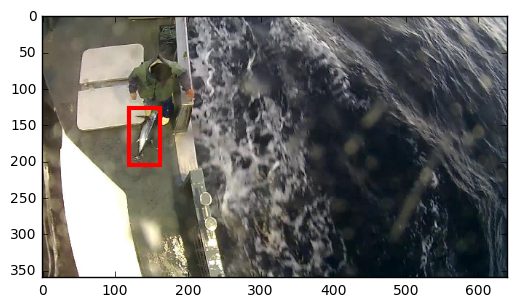

In [59]:
show_bb(3)

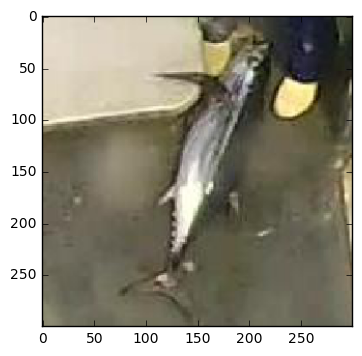

In [60]:
plot(val0[3])

In [61]:
del val0, val1
gc.collect()

91019

In [62]:
log.info('Read in data')
if not input_exists:
    for s in [0,1]:
        path = paths[s]
        load_size = load_sizes[s]
        # get labels
        (val_classes, trn_classes, val_labels, trn_labels,
            val_filenames, filenames, test_filenames) = get_classes(path)
        batches = get_batches(path+'train', batch_size=batch_size)
        val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
        
        # Create our VGG model
        log.info('Create VGG')
        vgg640 = Vgg16BN(load_size).model
        vgg640.pop()
        vgg640.input_shape, vgg640.output_shape
        vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

        # Fetch our large images 
        # Precompute the output of the convolutional part of VGG
        log.info('Fetch images')
        log.info('Get VGG output')
        log.info('Write VGG output')
        
        
        log.info('Valid weights%s'%(s))
        val = get_data(path+'valid', load_size)
        conv_val_feat = vgg640.predict(val, batch_size=16, verbose=1)
        save_array(path+'conv_val_crop%s_feat.dat'%(s), conv_val_feat) 
        del val, conv_val_feat
        gc.collect()

        log.info('Train weights%s'%(s))
        trn = get_data(path+'train', load_size)
        conv_trn_feat = vgg640.predict(trn, batch_size=16, verbose=1)    
        del trn
        gc.collect()
        save_array(path+'conv_trn_crop%s_feat.dat'%(s), conv_trn_feat) 
        del conv_trn_feat
        gc.collect()

        log.info('Test weights%s'%(s))
        test = get_data(path+'test', load_size)
        conv_test_feat = vgg640.predict(test, batch_size=16, verbose=1)
        save_array(path+'conv_test_crop%s_feat.dat'%(s), conv_test_feat)     
        del test, conv_test_feat
        gc.collect()

        # For memory purposes delete out the original train and validation
        log.info('Clear up memory')
        #del trn, val, test
        gc.collect()
        gc.collect()

[2017-02-27 21:32:00.242964] INFO: Logbook: Read in data


In [65]:
gc.collect()
conv_val_feat0  = load_array(paths[0]+'conv_val_crop0_feat.dat')
conv_trn_feat0  = load_array(paths[0]+'conv_trn_crop0_feat.dat') 
conv_test_feat0 = load_array(paths[0]+'conv_test_crop0_feat.dat')
conv_val_feat1  = load_array(paths[1]+'conv_val_crop1_feat.dat')
conv_trn_feat1  = load_array(paths[1]+'conv_trn_crop1_feat.dat') 
conv_test_feat1 = load_array(paths[1]+'conv_test_crop1_feat.dat')

In [68]:
if full:
    conv_trn_feat0 = np.concatenate([conv_trn_feat0, conv_val_feat0])
    conv_trn_feat1 = np.concatenate([conv_trn_feat1, conv_val_feat1])
    trn_labels = np.concatenate([trn_labels, val_labels]) 
    trn_bbox = np.concatenate([trn_bbox, val_bbox])
    
# Our Convolutional Net Architecture
log.info('Create and fit CNN')
# Set up the fully convolutional net (FCN); 
#conv_layers,_ = split_at(vgg640, Convolution2D)
#nf=128; p=0. # No dropout

[2017-02-27 21:38:51.770910] INFO: Logbook: Create and fit CNN


In [81]:
def get_layers(load_size):
    vgg640 = Vgg16BN(load_size).model
    vgg640.pop()
    vgg640.input_shape, vgg640.output_shape
    vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
    conv_layers,_ = split_at(vgg640, Convolution2D)
    return conv_layers
conv_layers1 = get_layers(load_sizes[1])
conv_layers0 = get_layers(load_sizes[0])
#conv_trn_feat0.shape
conv_layers0[-1].output_shape[1:]

(512, 18, 18)

In [84]:
gc.collect()
nf = 512
p  = 0.3
def create_model():
    inp0 = Input(conv_layers0[-1].output_shape[1:])
    inp1 = Input(conv_layers1[-1].output_shape[1:])
    x0 = MaxPooling2D()(inp0)
    x1 = MaxPooling2D()(inp1)
    x = ZeroPadding2D((1,1))(merge([x0,x1], 'concat'))
    #x = ZeroPadding2D((1,1))(x)
    x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    x =   Dropout(p)(x)
    x = BatchNormalization(axis=1)(x)
    #x = MaxPooling2D()(x)
    #x = ZeroPadding2D((1,1))(x)
    #x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    #x =   Dropout(p)(x)
    #x = BatchNormalization(axis=1)(x)
    x = MaxPooling2D()(x)
    x = ZeroPadding2D((1,1))(x)
    x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
    x =   Dropout(p)(x)
    x = BatchNormalization(axis=1)(x)
    x1 =   MaxPooling2D()(x)
    x1 =   Convolution2D(8,3,3, border_mode='same')(x1)
    x1 =   Dropout(p/2)(x1)
    x1 =   GlobalAveragePooling2D()(x1)
    x = Dropout(p/2)(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(p/2)(x)
    x_bb = Dense(4, name='bb')(x)
    x_class = Dense(8, activation='softmax', name='class')(x1)
    return inp0, inp1, x_bb, x_class

## Set up the fully convolutional net (FCN); 
#conv_layers,_ = split_at(vgg640, Convolution2D)
#nf=128; p=0. # No dropout

model = []
predsls = []
pvalsls = []

for ii in range(5):
    inp0, inp1,  x_bb, x_class = create_model()
    model.append(Model([inp0, inp1], [x_bb, x_class]))
    #model.summary()
    model[ii].compile(Adam(lr=1e-3), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
                 loss_weights=[.001, 1.])
    model[ii].fit([conv_trn_feat0, conv_trn_feat1], [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=5, 
                 validation_data=(merge([conv_val_feat0, conv_val_feat1], concat), [val_bbox, val_labels])) 

Exception: "concat" mode can only merge layers with matching output shapes except for the concat axis. Layer shapes: [(None, 512, 9, 9), (None, 512, 11, 20)]

In [69]:

    model[ii].fit([conv_trn_feat0, conv_trn_feat1], [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=5, 
                 validation_data=([conv_val_feat0, conv_val_feat1], [val_bbox, val_labels]))
    model[ii].optimizer.lr = 1e-4
    model[ii].optimizer.loss_weights=[.00001, 1.]
    model[ii].fit([conv_trn_feat0, conv_trn_feat1], [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=2, 
                 validation_data=([conv_val_feat0, conv_val_feat1], [val_bbox, val_labels]))
    model[ii].optimizer.lr = 1e-5

    count = 0
    while count < 8:
        model[ii].fit([conv_trn_feat0, conv_trn_feat1], [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=1, 
                     validation_data=([conv_val_feat0, conv_val_feat1], [val_bbox, val_labels]))
        predsls.append(model[ii].predict([conv_test_feat0, conv_test_feat1], batch_size=batch_size)[1]) # or try 32 batch_size
        pvalsls.append(model[ii].predict([conv_val_feat0, conv_val_feat1], batch_size=batch_size)[1])
        val_score = "%.3f" % metrics.log_loss(val_labels, sum(pvalsls)/len(pvalsls))
        acc_score = "%.3f" % accuracyfunc(val_labels, do_clip(sum(pvalsls)/len(pvalsls), clip))
        log.info('Bagged Validation Logloss ' + str(val_score))
        log.info('Bagged Validation Accuracy ' + str(acc_score))
        count += 1

th


Exception: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 arrays but instead got the following list of 2 arrays: [array([[[[  0.0000e+00,   0.0000e+00,   0.0000e+00, ...,   0.0000e+00,   0.0000e+00,   0.0000e+00],
         [  0.0000e+00,   0.0000e+00,   0.0000e+00, ...,   0.0000e+00,   0.0000e+00,   0.0000e+00],...